# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# Import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast # To parse string representation of lists as list

# Import category_encoders
# Source: https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d
from category_encoders import OneHotEncoder

# Import sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

# Magic word for producing visualizations in notebook
%matplotlib inline

# Set options to display more rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.sample(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
174072,-1,2,2,3.0,5,2,4,1,3,1,2,1972,2.0,1,2,35.0,11.0,10.0,5.0,10.0,5.0,1,11,2.0,2,2,4,7,2,3,5,5,7,4,7,7,7,7,2,0.0,0.0,1,2,17.0,3.0,0.0,4.0,2.0,2.0,9.0,1.0,0.0,1.0,2.0,1993.0,W,4.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,5.0,6.0,5.0,4.0,4.0,3.0,5.0,5.0,4.0,486.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,3.0,4.0,4.0
216011,-1,1,2,3.0,1,5,2,5,3,5,1,0,8.0,0,3,1.0,1.0,1.0,1.0,2.0,1.0,1,14,3.0,5,4,4,4,2,1,4,5,7,4,7,6,6,6,2,0.0,0.0,2,4,0.0,1.0,0.0,6.0,NaN,6.0,9.0,7.0,0.0,1.0,2.0,1993.0,O,3.0,8,8C,54,0.0,3.0,2.0,0.0,0.0,2.0,6.0,5.0,3.0,4.0,4.0,2.0,2.0,4.0,282.0,1.0,4.0,2.0,1.0,2.0,3.0,3.0,5.0,6.0,5.0
506418,-1,1,2,6.0,3,4,2,4,5,1,3,1982,5.0,0,3,10.0,3.0,1.0,1.0,9.0,4.0,1,14,1.0,2,2,5,4,1,2,2,3,6,4,6,4,7,6,0,0.0,0.0,2,5,18.0,1.0,0.0,5.0,NaN,4.0,8.0,2.0,0.0,1.0,4.0,1992.0,W,7.0,3,3C,24,4.0,1.0,0.0,0.0,1.0,4.0,3.0,2.0,6.0,5.0,2.0,5.0,3.0,3.0,831.0,3.0,2.0,0.0,0.0,1.0,4.0,5.0,2.0,1.0,1.0
431018,-1,4,2,5.0,4,3,4,4,3,1,6,1960,10.0,0,2,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,2,1,4,4,4,5,7,1,4,7,6,6,4,1,1,0.0,0.0,1,3,20.0,3.0,0.0,NaN,NaN,2.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712818,3,3,1,6.0,4,1,5,1,2,5,5,1947,5.0,0,1,0.0,0.0,0.0,0.0,1.0,1.0,1,5,5.0,3,6,4,6,7,6,4,5,5,5,5,2,1,4,3,0.0,0.0,1,6,11.0,0.0,0.0,6.0,NaN,NaN,3.0,7.0,0.0,1.0,1.0,1992.0,W,2.0,9,9D,51,0.0,0.0,3.0,0.0,3.0,2.0,3.0,6.0,3.0,4.0,2.0,2.0,1.0,7.0,894.0,1.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,8.0,3.0
422184,2,4,2,2.0,4,1,5,1,2,3,5,1948,7.0,1,2,40.0,12.0,11.0,5.0,10.0,5.0,1,6,5.0,1,1,1,3,3,7,7,2,3,7,5,6,4,3,3,0.0,0.0,1,1,18.0,4.0,0.0,4.0,2.0,2.0,9.0,1.0,0.0,1.0,3.0,1992.0,W,3.0,8,8A,51,1.0,2.0,0.0,0.0,0.0,3.0,1.0,6.0,2.0,4.0,3.0,3.0,4.0,6.0,488.0,1.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,8.0,5.0
410608,-1,3,1,3.0,3,4,2,3,4,2,4,0,4.0,0,3,30.0,9.0,9.0,5.0,4.0,2.0,3,14,1.0,6,6,4,1,5,1,4,6,2,5,2,3,4,2,2,0.0,0.0,2,4,19.0,2.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,1.0,3.0,1992.0,W,3.0,3,3C,24,2.0,2.0,0.0,0.0,0.0,3.0,2.0,3.0,4.0,4.0,3.0,5.0,2.0,6.0,335.0,4.0,2.0,1.0,0.0,1.0,2.0,3.0,2.0,4.0,2.0
345942,1,4,2,2.0,2,1,5,3,1,5,6,1941,7.0,0,2,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,1,1,3,2,5,7,2,2,6,6,5,2,1,3,0.0,0.0,1,3,10.0,1.0,0.0,6.0,NaN,6.0,1.0,3.0,0.0,1.0,5.0,1992.0,O,7.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,3.0,4.0,5.0,4.0,3.0,1.0,4.0,1300.0,2.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,3.0,2.0
529576,2,4,1,3.0,5,1,4,2,2,2,2,1932,12.0,0,1,12.0,3.0,1.0,1.0,9.0,4.0,1,1,3.0,3,6,2,6,7,5,3,4,1,3,1,2,4,1,3,0.0,0.0,1,3,8.0,1.0,0.0,2.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,2006.0,O,7.0,2,2C,14,NaN,NaN,NaN,NaN,NaN,NaN,7.0,3.0,7.0,5.0,NaN,NaN,2.0,NaN,336.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,3.0,3.0,2.0
15798,-1,1,1,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
def parse_missing_or_known(str_literal):
    str_literal = str_literal.strip('[')
    str_literal = str_literal.strip(']')
    
    return str_literal.split(',')

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].map(parse_missing_or_known)
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Fill all empty strings with NaNs
azdias.replace(r'\s+', np.nan, inplace=True)

# Loop through each row in feat_info to convert missing values in azdias to NaN
for idx in feat_info.index:
    if len(feat_info.loc[idx, 'missing_or_unknown']) > 0:
        for value in feat_info.loc[idx, 'missing_or_unknown']:
            try:
                value = int(value)
            except ValueError:
                None
            azdias[feat_info.loc[idx, 'attribute']].replace(value, np.nan, inplace=True)

In [7]:
azdias.sample(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
190073,NaN,2.0,1,4.0,3,3,4,2,2,2,6,1963.0,8.0,0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,3.0,7,7,6,7,6,3,1,7,4,5,4,4,6,5,2.0,0.0,NaN,1.0,6,14.0,1.0,0.0,5.0,NaN,4.0,8.0,4.0,0.0,1.0,1.0,1992.0,W,4.0,7,7A,41,3.0,0.0,1.0,0.0,1.0,3.0,6.0,3.0,6.0,4.0,2.0,3.0,1.0,4.0,854.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,3.0,6.0,2.0
811882,NaN,3.0,2,6.0,1,4,1,4,3,4,6,1981.0,9.0,0,3.0,21.0,6.0,4.0,3.0,2.0,1.0,1.0,14.0,2.0,5,2,3,5,2,4,6,3,4,6,4,7,4,2,2.0,0.0,NaN,1.0,4,18.0,1.0,0.0,6.0,5.0,1.0,9.0,64.0,0.0,3.0,3.0,1992.0,O,5.0,9,9A,52,1.0,0.0,0.0,1.0,NaN,2.0,1.0,6.0,2.0,2.0,3.0,1.0,5.0,5.0,438.0,1.0,0.0,2.0,2.0,5.0,4.0,1.0,4.0,9.0,3.0
619541,3.0,3.0,2,2.0,2,1,5,1,1,5,5,NaN,12.0,0,3.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5,3,1,3,4,4,6,1,4,5,7,7,1,3,2.0,0.0,NaN,2.0,3,7.0,1.0,0.0,5.0,NaN,6.0,9.0,20.0,0.0,1.0,1.0,1992.0,W,3.0,8,8B,41,0.0,0.0,0.0,2.0,4.0,1.0,4.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,822.0,1.0,3.0,2.0,1.0,5.0,5.0,5.0,4.0,5.0,5.0
23267,NaN,2.0,1,4.0,2,5,1,4,4,3,4,1981.0,12.0,0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,14.0,1.0,7,7,6,7,6,3,3,7,4,2,4,2,7,5,3.0,0.0,NaN,1.0,5,18.0,1.0,0.0,6.0,NaN,4.0,8.0,5.0,0.0,1.0,5.0,1993.0,W,4.0,8,8A,51,1.0,4.0,1.0,0.0,NaN,3.0,7.0,2.0,8.0,4.0,4.0,2.0,2.0,5.0,554.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,4.0,5.0
883427,NaN,3.0,2,4.0,5,2,4,5,2,1,6,1960.0,1.0,0,3.0,37.0,12.0,10.0,5.0,9.0,4.0,1.0,8.0,3.0,3,2,3,3,5,4,6,3,4,4,4,5,5,3,2.0,1.0,NaN,1.0,3,18.0,3.0,0.0,4.0,NaN,2.0,9.0,1.0,0.0,1.0,3.0,1992.0,W,7.0,2,2B,13,3.0,1.0,0.0,0.0,1.0,5.0,7.0,2.0,7.0,5.0,4.0,5.0,3.0,5.0,423.0,4.0,1.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0
261460,1.0,3.0,1,2.0,5,1,5,2,2,2,2,1948.0,10.0,0,3.0,38.0,12.0,10.0,5.0,9.0,4.0,1.0,5.0,4.0,6,4,4,1,5,4,4,6,2,3,5,3,3,4,0.0,0.0,NaN,2.0,1,NaN,3.0,0.0,2.0,5.0,2.0,9.0,1.0,0.0,1.0,3.0,1992.0,W,7.0,4,4A,22,4.0,1.0,0.0,0.0,1.0,3.0,6.0,1.0,5.0,3.0,4.0,5.0,2.0,6.0,227.0,4.0,1.0,0.0,0.0,1.0,2.0,3.0,2.0,1.0,2.0
598156,NaN,2.0,1,6.0,3,4,3,5,5,3,4,NaN,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11588,2.0,1.0,2,3.0,5,1,5,1,1,2,6,NaN,6.0,1,NaN,13.0,3.0,1.0,1.0,10.0,5.0,NaN,2.0,5.0,1,4,4,3,1,7,7,2,6,7,5,6,5,3,NaN,1.0,NaN,NaN,2,8.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,3.0,1992.0,W,1.0,1,1C,14,2.0,2.0,0.0,0.0,NaN,4.0,3.0,4.0,5.0,4.0,1.0,4.0,2.0,2.0,323.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,1.0,4.0,1.0
617867,NaN,1.0,2,6.0,2,5,2,5,3,2,6,1986.0,5.0,0,3.0,30.0,9.0,11.0,5.0,4.0,2.0,1.0,14.0,4.0,1,4,4,4,1,2,2,3,6,4,6,4,6,6,0.0,0.0,NaN,2.0,5,20.0,4.0,0.0,6.0,NaN,2.0,9.0,2.0,0.0,1.0,4.0,1992.0,W,7.0,4,4C,24,2.0,2.0,0.0,0.0,NaN,3.0,7.0,1.0,8.0,3.0,2.0,3.0,4.0,2.0,2000.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,3.0,3.0
819238,NaN,3.0,1,2.0,5,2,4,2,3,1,6,NaN,5.0,0,3.0,9.0,3.0,1.0,1.0,7.0,3.0,1.0,10.0,5.0,4,5,4,6,5,6,4,6,5,5,5,3,3,4,1.0,0.0,NaN,2.0,1,15.0,1.0,0.0,2.0,NaN,6.0,9.0,1.0,0.0,1.0,3.0,1992.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

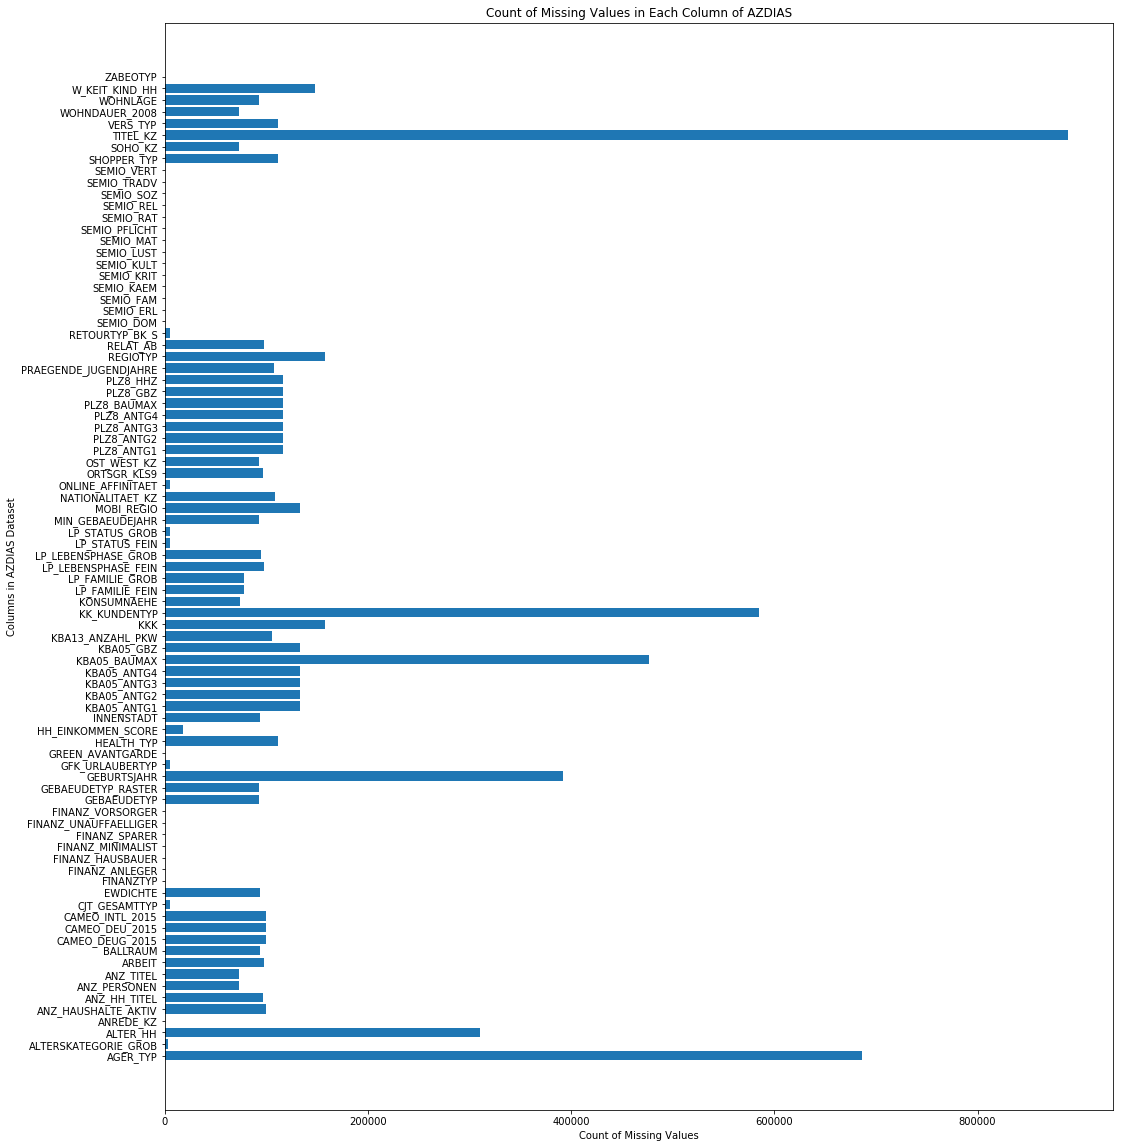

In [8]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_cols_desc = azdias.isnull().sum()

plt.figure(figsize=(17,20))
plt.barh(y=missing_cols_desc.index, height=0.8, width=missing_cols_desc.values)
plt.title('Count of Missing Values in Each Column of AZDIAS')
plt.xlabel('Count of Missing Values')
plt.ylabel('Columns in AZDIAS Dataset')
plt.show()

In [9]:
# Investigate patterns in the amount of missing data in each column.
missing_cols_desc.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Get columns that miss more than 200K values
outlier_columns = missing_cols_desc[missing_cols_desc > 200000]
# Delete columns that miss more than 200K values
azdias.drop(labels=outlier_columns.index.tolist(), inplace=True, axis=1)
azdias.sample(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
438891,3.0,1,2.0,5,2,4,2,2,1,6,3.0,1,3.0,39.0,12.0,10.0,5.0,10.0,5.0,3.0,9.0,3.0,6,6,4,4,7,6,4,5,2,3,5,2,3,4,1.0,0.0,2.0,1,3.0,0.0,1.0,4.0,9.0,2.0,0.0,1.0,4.0,1992.0,W,7.0,2,2D,14,2.0,1.0,0.0,0.0,5.0,7.0,4.0,8.0,5.0,2.0,3.0,4.0,6.0,789.0,2.0,2.0,0.0,0.0,1.0,5.0,5.0,4.0,4.0,3.0
142357,2.0,2,4.0,1,4,1,5,3,5,6,12.0,0,2.0,21.0,6.0,4.0,3.0,2.0,1.0,1.0,14.0,2.0,2,5,7,7,2,3,5,5,7,7,7,7,6,7,2.0,0.0,1.0,4,1.0,0.0,6.0,1.0,4.0,4.0,0.0,8.0,2.0,1992.0,O,3.0,8,8A,51,2.0,3.0,0.0,0.0,3.0,2.0,4.0,1.0,3.0,3.0,3.0,5.0,5.0,205.0,1.0,3.0,3.0,2.0,4.0,2.0,1.0,4.0,4.0,5.0
426276,1.0,1,5.0,2,4,1,3,4,4,4,2.0,0,2.0,29.0,9.0,10.0,5.0,1.0,1.0,2.0,14.0,1.0,7,7,7,5,7,3,1,7,4,2,1,2,6,5,0.0,0.0,1.0,4,4.0,0.0,6.0,2.0,9.0,16.0,0.0,8.0,1.0,1992.0,O,3.0,9,9C,51,0.0,0.0,2.0,1.0,1.0,1.0,6.0,2.0,3.0,3.0,1.0,4.0,6.0,52.0,0.0,2.0,3.0,2.0,5.0,2.0,1.0,4.0,9.0,3.0
533703,4.0,2,6.0,4,3,4,4,4,1,3,9.0,0,3.0,27.0,8.0,8.0,4.0,9.0,4.0,1.0,10.0,1.0,2,3,4,4,4,4,7,1,4,7,4,5,4,4,1.0,0.0,1.0,2,3.0,0.0,2.0,1.0,9.0,1.0,0.0,1.0,5.0,1999.0,W,5.0,2,2B,13,NaN,NaN,NaN,NaN,NaN,6.0,3.0,6.0,4.0,NaN,NaN,5.0,NaN,588.0,3.0,2.0,1.0,0.0,1.0,4.0,5.0,4.0,4.0,5.0
551204,3.0,2,2.0,4,1,5,1,1,3,2,7.0,0,NaN,38.0,12.0,10.0,5.0,9.0,4.0,NaN,5.0,2.0,1,4,4,4,1,5,7,3,6,4,5,4,7,3,NaN,0.0,NaN,3,4.0,0.0,3.0,2.0,9.0,1.0,0.0,8.0,2.0,1992.0,W,3.0,7,7C,54,2.0,1.0,0.0,0.0,4.0,6.0,2.0,6.0,4.0,2.0,3.0,2.0,4.0,536.0,2.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,2.0
89352,3.0,1,5.0,4,2,3,3,1,2,6,5.0,0,3.0,11.0,3.0,1.0,1.0,9.0,4.0,1.0,8.0,4.0,3,5,4,2,5,4,4,6,2,5,5,2,3,4,0.0,0.0,2.0,4,1.0,0.0,4.0,4.0,7.0,3.0,0.0,1.0,3.0,1995.0,O,3.0,4,4C,24,1.0,2.0,0.0,0.0,3.0,7.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,896.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,3.0,5.0,3.0
541895,1.0,2,3.0,1,5,3,5,4,5,1,11.0,0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,14.0,4.0,1,4,7,4,2,3,2,5,7,7,4,6,7,6,2.0,0.0,1.0,4,1.0,0.0,6.0,6.0,4.0,6.0,0.0,1.0,3.0,1992.0,W,5.0,8,8A,51,0.0,0.0,3.0,0.0,2.0,6.0,5.0,6.0,4.0,4.0,1.0,4.0,6.0,360.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,5.0,5.0,5.0
326083,1.0,2,6.0,4,4,1,4,4,2,4,1.0,0,3.0,10.0,3.0,1.0,1.0,9.0,4.0,1.0,14.0,3.0,2,4,5,4,1,2,4,3,6,6,6,4,7,6,3.0,0.0,2.0,5,1.0,0.0,5.0,3.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,3.0,3.0,0.0,0.0,3.0,5.0,2.0,7.0,5.0,2.0,5.0,3.0,4.0,808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,4.0
379813,3.0,2,5.0,1,5,2,5,5,5,1,8.0,0,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,NaN,5.0,2,5,7,5,2,5,7,6,4,6,6,6,6,3,NaN,0.0,NaN,3,1.0,0.0,6.0,NaN,9.0,8.0,0.0,8.0,3.0,1992.0,W,5.0,8,8C,54,0.0,4.0,1.0,0.0,3.0,1.0,6.0,3.0,4.0,4.0,3.0,1.0,4.0,459.0,2.0,3.0,2.0,1.0,1.0,4.0,3.0,4.0,8.0,3.0
344580,4.0,1,4.0,3,3,4,3,2,3,6,1.0,0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,6,4,3,4,6,5,3,6,3,3,3,3,3,4,2.0,0.0,1.0,6,1.0,0.0,6.0,5.0,9.0,12.0,0.0,1.0,2.0,1992.0,W,4.0,8,8A,51,0.0,2.0,3.0,0.0,3.0,3.0,6.0,2.0,3.0,3.0,2.0,2.0,6.0,474.0,1.0,4.0,3.0,2.0,4.0,4.0,3.0,4.0,7.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Here, I elected to drop all 6 columns that miss more than 200K.

The columns that were drop (and the count of missing values in those columns) can be seen in the cell below.

In [11]:
outlier_columns

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
missing_rows_desc = azdias.isnull().sum(axis=1)
missing_rows_desc.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [13]:
# Even if we remove all rows with missing values, we can still maintain 66.66% of our data
'Percentage of rows with no missing columns: {:.2%}'.format(
    len(missing_rows_desc[missing_rows_desc == 0]) / len(missing_rows_desc)
)

'Percentage of rows with no missing columns: 69.93%'

#### Personal note

From here on, I will call the group of rows that miss only a few values "group of dense rows", and the group of rows that miss a lot of values "group of sparse rows"

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Sparse rows: miss at least 16 values
# Dense rows: don't miss any values
criteria = missing_rows_desc > 15
azdias_sparse_rows = azdias.loc[criteria]
azdias_dense_rows = azdias.drop(azdias_sparse_rows.index)

In [15]:
# Find columns that don't miss values, or miss only a few values
missing_cols_desc[missing_cols_desc <= 15]

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

In [16]:
# Pick a few columns
selected_columns_to_compare = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 
                               'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_FAM']

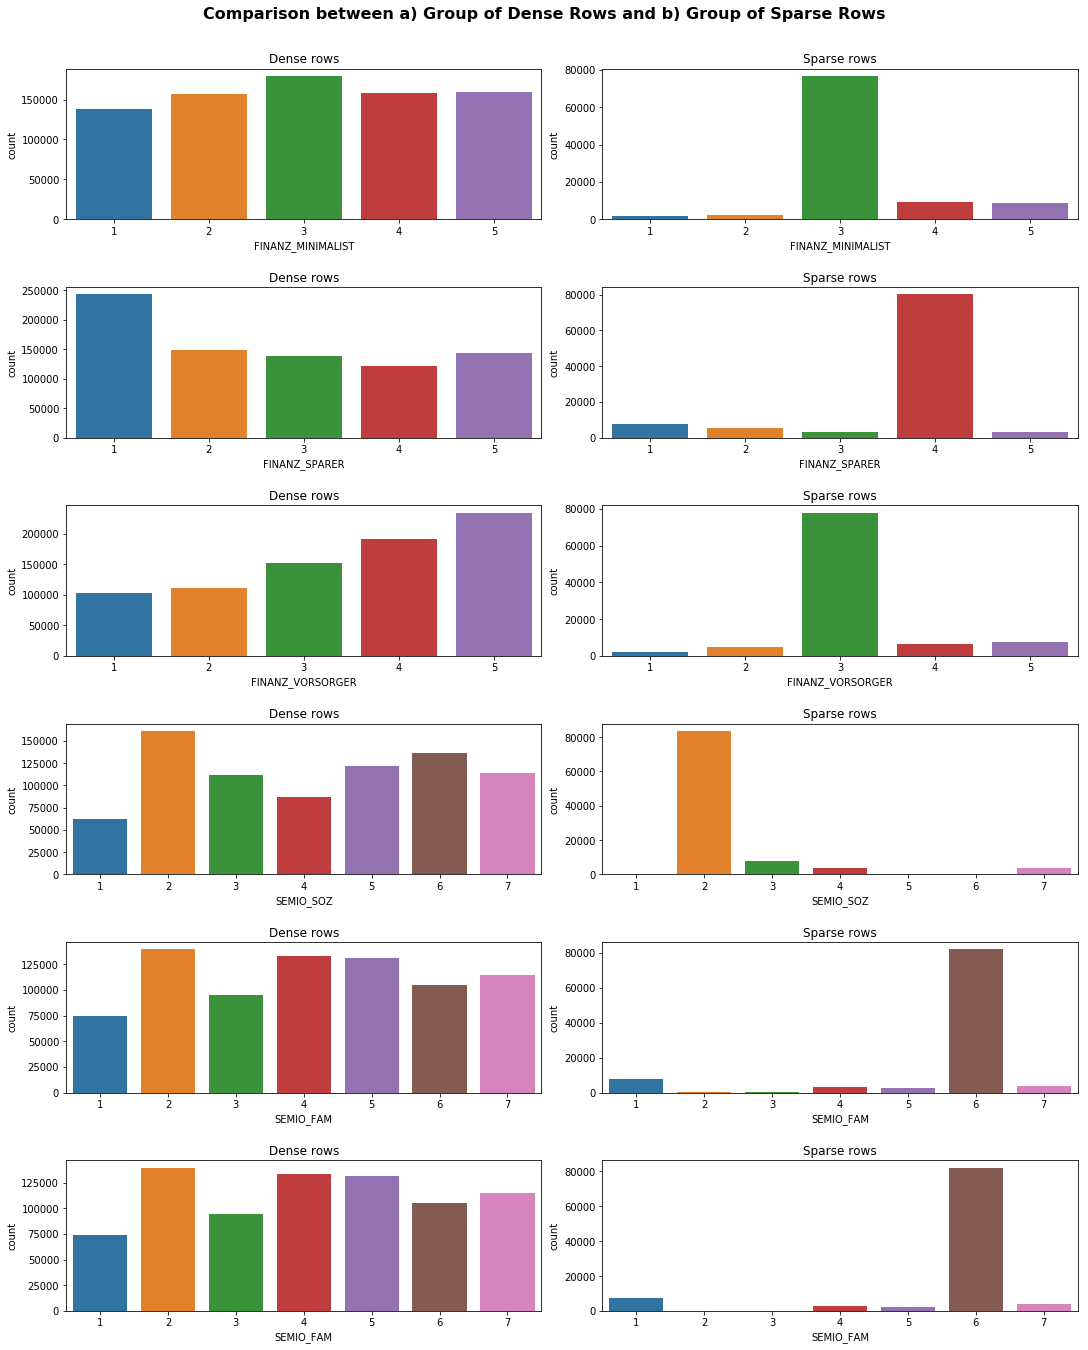

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
plt.figure(figsize=(17,20))

plt.suptitle('Comparison between a) Group of Dense Rows and b) Group of Sparse Rows', fontsize=16, weight=750)
for idx, column in enumerate(selected_columns_to_compare):
    plt.subplot(len(selected_columns_to_compare), 2, idx*2+1)
    sns.countplot(x=column, data=azdias_dense_rows)
    plt.title('Dense rows')
    plt.subplot(len(selected_columns_to_compare), 2, idx*2+2)
    sns.countplot(x=column, data=azdias_sparse_rows)
    plt.title('Sparse rows')
plt.tight_layout(pad=7.5, w_pad=0.5, h_pad=2.0)
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the charts above, it is apparent that the data between the two groups vary substantially. 

This calls for retaining and revisiting the group of sparse rows later.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
feat_info.groupby('type').agg({'attribute': 'count'})

,attribute
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Get list of all columns that were not dropped and were categorical
categorical_cols = feat_info[(~feat_info['attribute'].isin(outlier_columns.index)) 
                             & (feat_info['type'] == 'categorical')].attribute.tolist()
categorical_cols

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Convert the remaining categorical columns to datatype 'category' first
for col in categorical_cols:
    azdias_dense_rows.loc[:, col] = azdias_dense_rows.loc[:, col].astype('category')

# Get a description
categorical_description = azdias_dense_rows.loc[:, categorical_cols].describe().transpose().sort_values('unique')
categorical_description

,count,unique,top,freq
ANREDE_KZ,792287,2,2,413088
OST_WEST_KZ,792287,2,W,624737
VERS_TYP,756432,2,2,393160
SOHO_KZ,792287,2,0,785624
GREEN_AVANTGARDE,792287,2,0,618002
NATIONALITAET_KZ,759172,3,1,663519
SHOPPER_TYP,756432,4,1,245332
LP_STATUS_GROB,787919,5,1,316929
LP_FAMILIE_GROB,761776,5,1,399976
FINANZTYP,792287,6,6,288550


In [21]:
# Turns OST_WEST_KZ into ints
mapping = {'O': 0, 'W': 1}
azdias_dense_rows.replace({'OST_WEST_KZ': mapping}, inplace=True)
# Define list of columns to encode
category_columns = categorical_description[categorical_description['unique'] > 2].index
onehotenc = OneHotEncoder(cols=category_columns)
# Encode those columns
onehotenc.fit(X=azdias_dense_rows.loc[:, category_columns])
category_dummies = onehotenc.get_dummies(X_in=azdias_dense_rows.loc[:, category_columns], cols=category_columns)
# Merge with original dataframe
azdias_dense_rows = azdias_dense_rows.merge(category_dummies, left_index=True, right_index=True)
azdias_dense_rows.shape

(792287, 230)

#### Discussion 1.2.1: Re-Encode Categorical Features

Since most of the categorical data with more than 2 values have a quite equal distribution of values, I opted to make dummy variables out of them instead of dropping them. Here I use a combination of backfilling NaNs, LabelEncoder, and OneHotEncoder, in an attempt to make the cleaning process reproducable in the clean_data() function later on

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# How many features are there of each data type?
feat_info.groupby('type').agg({'attribute': 'count'})

,attribute
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create a dictionary that map original values to encoded decades e.g. 3.0 is mapped to 2, for the 50s
decade_replace = {
    1.0: 1, 2.0: 1,
    3.0: 2, 4.0: 2,
    5.0: 3, 6.0: 3, 7.0: 3,
    8.0: 4, 9.0: 4,
    10.0: 5, 11.0: 5, 12.0: 5, 13.0: 5,
    14.0: 6, 15.0: 6
}
# Replace the original values to encoded decades as per the map
azdias_dense_rows['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_dense_rows['PRAEGENDE_JUGENDJAHRE'].map(decade_replace)
# Replace the original values to encoded movements 
# e.g. all even numbers mapped to 1 for avant garde, 
# odd to 0 for mainstream
azdias_dense_rows['PRAEGENDE_JUGENDJAHRE_MVMENT'] = azdias_dense_rows['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: 0 if x % 2 == 1 else 1
)

PRARGENDE_columns = [column for column in azdias_dense_rows if column.startswith('PRAEGENDE_JUGENDJAHRE')]
azdias_dense_rows.loc[:, PRARGENDE_columns].sample(10)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MVMENT
840965,10.0,5.0,1
251979,11.0,5.0,0
203875,8.0,4.0,1
8328,5.0,3.0,0
264727,14.0,6.0,1
807625,14.0,6.0,1
8678,5.0,3.0,0
462784,14.0,6.0,1
443479,14.0,6.0,1
798526,8.0,4.0,1


In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Fill missing values in "CAMEO_INTL_2015" - since there are few missing values, I'm using naive backfill method
azdias_dense_rows['CAMEO_INTL_2015'].fillna(method='backfill', inplace=True)
azdias_dense_rows['CAMEO_INTL_2015_WEALTH'] = azdias_dense_rows['CAMEO_INTL_2015'].apply(
    lambda x: int(x[0])
)
azdias_dense_rows['CAMEO_INTL_2015_LIFEST'] = azdias_dense_rows['CAMEO_INTL_2015'].apply(
    lambda x: int(x[1])
)
CAMEO_INTL_columns = [column for column in azdias_dense_rows if column.startswith('CAMEO_INTL_2015')]
azdias_dense_rows.loc[:, CAMEO_INTL_columns].sample(10)

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFEST
33311,51,5,1
453553,55,5,5
474367,43,4,3
278066,14,1,4
528525,25,2,5
599983,33,3,3
868484,51,5,1
684727,31,3,1
270590,14,1,4
254230,51,5,1


#### Discussion 1.2.2: Engineer Mixed-Type Features

I kept two of these mixed features. The rest I would leave out of the remaining learning process.

For 'PRAEGENDE_JUGENDJAHRE', I couldn't find an efficient way to get decade from the original encoding, so I manually wrote a mapping dictionary. Also with 'PRAEGENDE_JUGENDJAHRE', fortunately, it is easy to get movement from the original encoding: all odd values belong to the Mainstream movement, all even values belong to the Avant Garde movement.

For 'CAMEO_INTL_2015', since the original encoding is still of type 'str', it is easy to split the two letters into two columns then convert the letters to integers for parsing.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# Get list of all columns that were not dropped and were mixed
mixed_cols = feat_info[(~feat_info['attribute'].isin(outlier_columns.index)) 
                       & (feat_info['type'] == 'mixed')].attribute.tolist()
# Get list of all columns that were recently encoded into new columns in the previous steps
# including all categorical columns and two mixed columns
encoded_cols = categorical_cols + ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'] 

In [26]:
encoded_cols

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'PRAEGENDE_JUGENDJAHRE',
 'CAMEO_INTL_2015']

In [38]:
# Get list of columns to keep to pass to algorithms
save_cols = azdias_dense_rows.columns.tolist()
save_cols = [i for i in save_cols if i not in mixed_cols + encoded_cols]

In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_dense_rows.loc[:, save_cols].sample(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,...,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,CAMEO_DEU_2015_45,CAMEO_DEU_2015_-1,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MVMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFEST
741300,4.0,5,1,4,1,1,4,2.0,5.0,6,2,3,1,7,7,7,4,1,3,3,3,2,2,3.0,0.0,2.0,2.0,9.0,1.0,0.0,4.0,1994.0,1.0,3.0,0.0,0.0,3.0,7.0,1.0,8.0,5.0,4.0,3.0,2.0,5.0,519.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1,4,5
248764,3.0,4,2,4,2,3,2,1.0,5.0,4,4,4,6,5,6,4,5,5,3,5,3,3,4,3.0,0.0,3.0,6.0,9.0,8.0,0.0,2.0,1992.0,0.0,2.0,3.0,0.0,3.0,4.0,6.0,2.0,4.0,4.0,2.0,3.0,7.0,293.0,2.0,3.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1,2,4
358655,3.0,4,2,4,3,3,1,3.0,5.0,2,3,3,3,2,1,6,3,4,7,7,7,4,2,3.0,0.0,4.0,1.0,9.0,1.0,0.0,4.0,1995.0,4.0,1.0,0.0,0.0,3.0,6.0,5.0,3.0,4.0,3.0,3.0,4.0,5.0,571.0,2.0,3.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1,4,3
211608,4.0,4,1,5,1,5,2,2.0,3.0,5,3,2,5,4,5,7,1,2,6,6,5,2,3,2.0,0.0,4.0,4.0,9.0,2.0,0.0,5.0,1996.0,1.0,1.0,0.0,0.0,5.0,7.0,1.0,8.0,4.0,2.0,5.0,4.0,4.0,669.0,2.0,3.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,2,2
513389,3.0,5,3,3,5,4,1,3.0,5.0,3,6,4,1,7,4,4,5,2,5,2,4,4,2,1.0,0.0,4.0,1.0,8.0,1.0,0.0,5.0,2008.0,NaN,NaN,NaN,NaN,NaN,6.0,4.0,5.0,4.0,3.0,NaN,5.0,5.0,230.0,3.0,3.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1,2,4
784964,1.0,1,4,1,4,4,5,1.0,1.0,5,4,5,3,3,3,2,5,7,4,6,6,6,6,1.0,0.0,4.0,4.0,7.0,20.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,1.0,6.0,1.0,1.0,3.0,1.0,3.0,6.0,345.0,1.0,1.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,1,4,1
556306,3.0,4,3,4,4,2,1,3.0,3.0,5,3,3,2,4,4,6,3,4,4,4,5,5,4,2.0,0.0,3.0,1.0,9.0,1.0,0.0,5.0,1997.0,3.0,1.0,0.0,0.0,4.0,4.0,2.0,5.0,5.0,NaN,5.0,4.0,NaN,1050.0,3.0,3.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1,3,2
754094,4.0,3,1,5,1,1,5,1.0,5.0,2,2,1,2,2,5,7,2,3,6,5,6,3,3,2.0,0.0,6.0,6.0,9.0,5.0,0.0,5.0,1992.0,2.0,3.0,0.0,0.0,3.0,1.0,6.0,3.0,4.0,3.0,3.0,1.0,6.0,434.0,2.0,3.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,5,1
822876,3.0,4,2,3,2,2,2,3.0,5.0,6,6,4,4,7,4,4,5,2,5,5,2,3,4,1.0,0.0,5.0,4.0,9.0,6.0,0.0,3.0,1992.0,1.0,2.0,1.0,0.0,3.0,1.0,6.0,1.0,4.0,4.0,3.0,2.0,4.0,388.0,2.0,2.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
outlier_columns

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [30]:
def clean_data(df, feat_info, outlier_columns, onehotenc):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    ## Convert missing value codes into NaNs, ...
    print('Converting missing value codes into NaNs, ...')
    # Fill all empty strings with NaNs
    df.replace(r'\s+', np.nan, inplace=True)
    # Loop through each row in feat_info to convert missing values in azdias to NaN
    for idx in feat_info.index:
        if len(feat_info.loc[idx, 'missing_or_unknown']) > 0:
            for value in feat_info.loc[idx, 'missing_or_unknown']:
                try:
                    value = int(value)
                except ValueError:
                    None
                df[feat_info.loc[idx, 'attribute']].replace(value, np.nan, inplace=True)
    
    ## Remove selected columns and rows, ...    
    # Count missing values from each column
    missing_cols_desc = df.isnull().sum()
    # Delete outlier_columns
    df.drop(labels=outlier_columns.index.tolist(), inplace=True, axis=1)
    print('### Number of features now: {}'.format(len(df.columns)))
    # Count missing values from each rows
    missing_rows_desc = df.isnull().sum(axis=1)
    # Select only rows that has no missing values
    # Sparse rows: miss at least 16 values
    # Dense rows: don't miss any values
    criteria = missing_rows_desc > 15
    df_sparse_rows = df.loc[criteria]
    df = df.drop(df_sparse_rows.index)
    print('### Number of features now: {}'.format(len(df.columns)))
    
    ## Select, re-encode, and engineer column values.
    ## Category features
    print('Encoding category features...')
    # Turns OST_WEST_KZ into ints
    mapping = {'O': 0, 'W': 1}
    df.replace({'OST_WEST_KZ': mapping}, inplace=True)
    # Get list of all columns that were not dropped and were categorical
    categorical_cols = feat_info[(~feat_info['attribute'].isin(outlier_columns.index)) 
                                 & (feat_info['type'] == 'categorical')].attribute.tolist()
    print(len(categorical_cols))
    # Convert the remaining categorical columns to datatype 'category' first
    for col in categorical_cols:
        df.loc[:, col] = df.loc[:, col].astype('category')
    # Get a description
    categorical_description = df.loc[:, categorical_cols].describe().transpose().sort_values('unique')
    categorical_description
    # Define list of columns to encode
    category_columns = categorical_description[categorical_description['unique'] > 2].index
    # Encode those columns
    onehotenc.fit(X=df.loc[:, category_columns])
    category_dummies = onehotenc.get_dummies(X_in=df.loc[:, category_columns], cols=category_columns)
    # Merge with original dataframe
    df = df.merge(category_dummies, left_index=True, right_index=True)
    print('### Number of features now: {}'.format(len(df.columns)))
    ## Mixed features
    print('Encoding mixed features...')
    # Create a dictionary that map original values to encoded decades e.g. 3.0 is mapped to 2, for the 50s
    decade_replace = {
        1.0: 1, 2.0: 1,
        3.0: 2, 4.0: 2,
        5.0: 3, 6.0: 3, 7.0: 3,
        8.0: 4, 9.0: 4,
        10.0: 5, 11.0: 5, 12.0: 5, 13.0: 5,
        14.0: 6, 15.0: 6
    }
    # Replace the original values to encoded decades as per the map
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_replace)
    # Replace the original values to encoded movements 
    # e.g. all even numbers mapped to 1 for avant garde, 
    # odd to 0 for mainstream
    df['PRAEGENDE_JUGENDJAHRE_MVMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: 0 if x % 2 == 1 else 1
    )
    # Fill missing values in 'CAMEO_INTL_2015'
    df['CAMEO_INTL_2015'].fillna(method='backfill', inplace=True)
    # Split CAMEO_INTL into two new columns
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(
        lambda x: int(x[0])
    )
    df['CAMEO_INTL_2015_LIFEST'] = df['CAMEO_INTL_2015'].apply(
        lambda x: int(x[1])
    )
    print('### Number of features now: {}'.format(len(df.columns)))
    ## Return the cleaned dataframe.
    print('Returning the cleaned dataframe...')
    # Get list of all columns that were not dropped and were mixed
    mixed_cols = feat_info[(~feat_info['attribute'].isin(outlier_columns.index)) 
                           & (feat_info['type'] == 'mixed')].attribute.tolist()
    # Get list of all columns that were recently encoded into new columns in the previous steps
    # including all categorical columns and two mixed columns
    encoded_cols = categorical_cols + ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'] 
    # Get list of columns to keep to pass to algorithms
    save_cols = df.columns.tolist()
    save_cols = [i for i in save_cols if i not in mixed_cols + encoded_cols]
    print('### Number of features now: {}'.format(len(save_cols)))
    return df.loc[:, save_cols]

In [31]:
outlier_columns

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [32]:
# Sanity check
test_df_1 = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
clean_df_1 = clean_data(test_df_1, feat_info=feat_info, outlier_columns=outlier_columns, onehotenc=onehotenc).columns

Converting missing value codes into NaNs, ...
### Number of features now: 79
### Number of features now: 79
Encoding category features...
18
### Number of features now: 230
Encoding mixed features...
### Number of features now: 234
Returning the cleaned dataframe...
### Number of features now: 210


In [33]:
test_df_2 = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
clean_df_2 = clean_data(test_df_2, feat_info=feat_info, outlier_columns=outlier_columns, onehotenc=onehotenc).columns

Converting missing value codes into NaNs, ...
### Number of features now: 79
### Number of features now: 79
Encoding category features...
18
### Number of features now: 229
Encoding mixed features...
### Number of features now: 233
Returning the cleaned dataframe...
### Number of features now: 209


In [82]:
save_cols.remove([i for i in clean_df_1.tolist() if i not in clean_df_2.tolist()][0])

In [37]:
# Can't standardize further, will drop this column from population
azdias_dense_rows = azdias_dense_rows.drop([i for i in clean_df_1.tolist() if i not in clean_df_2.tolist()][0], axis=1)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# Apply feature scaling to the general population demographics data.
imputer = Imputer(strategy='most_frequent', copy=False)
print('Imputing...')
azdias_dense_rows.loc[:, save_cols] = imputer.fit_transform(azdias_dense_rows.loc[:, save_cols])
print('Imputing done!')
scaler = StandardScaler()
print('Scaling...')
azdias_dense_rows.loc[:, save_cols] = scaler.fit_transform(azdias_dense_rows.loc[:, save_cols])
print('Scaling done!')

Imputing...
Imputing done!
Scaling...
Scaling done!


### Discussion 2.1: Apply Feature Scaling

Here, I'm using Scikit-Learn's naive imputer, filing in NaNs with the most common value.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [41]:
# Apply PCA to the data.
pca = PCA()
azdias_dense_rows_pca = pca.fit_transform(azdias_dense_rows.loc[:, save_cols])

In [42]:
# Referred from the lessons
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

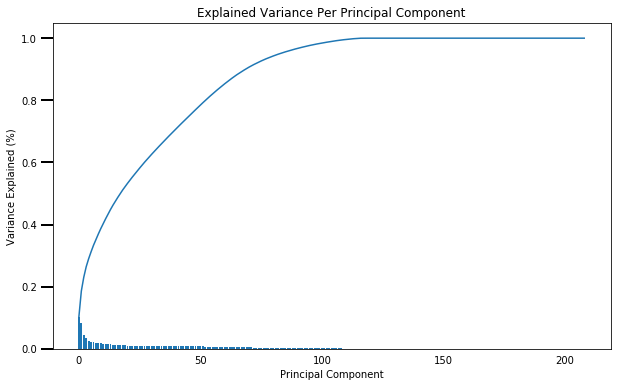

In [43]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [44]:
# Re-apply PCA to the data while selecting for number of components to retain.
for i in np.arange(5, len(save_cols), 5):
    print('For {} components, explained variance: {:0.2%} (increase {:0.2%})'.format(
        i, pca.explained_variance_ratio_[:i].sum(), pca.explained_variance_ratio_[i-5:i].sum()
    ))
    
pca_55 = PCA(n_components=55)
azdias_dense_rows_pca_55 = pca_55.fit_transform(azdias_dense_rows.loc[:, save_cols])

For 5 components, explained variance: 28.98% (increase 28.98%)
For 10 components, explained variance: 38.68% (increase 9.71%)
For 15 components, explained variance: 46.21% (increase 7.53%)
For 20 components, explained variance: 52.21% (increase 6.00%)
For 25 components, explained variance: 57.23% (increase 5.02%)
For 30 components, explained variance: 61.82% (increase 4.59%)
For 35 components, explained variance: 66.02% (increase 4.20%)
For 40 components, explained variance: 70.05% (increase 4.02%)
For 45 components, explained variance: 73.93% (increase 3.88%)
For 50 components, explained variance: 77.72% (increase 3.79%)
For 55 components, explained variance: 81.36% (increase 3.64%)
For 60 components, explained variance: 84.69% (increase 3.33%)
For 65 components, explained variance: 87.68% (increase 2.99%)
For 70 components, explained variance: 90.21% (increase 2.54%)
For 75 components, explained variance: 92.29% (increase 2.07%)
For 80 components, explained variance: 93.97% (increase

### Discussion 2.2: Perform Dimensionality Reduction

* Out of 200 components, 10 components (5% of 200) account for 38% of variance
* Out of 200 components, only 120 components (60% of 200) are useful - because the remaining components add no further value in terms of variance accounted for.
* I'm choosing to reapply PCA and take 55 components - partly arbitrarily, admittedly.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(full_dataset, pca):
    # Create dimensions index
    dimensions = ['Principle Component #{}'.format(i) for i \
                  in range(1, len(pca.components_) + 1)]
    
    # Capture pca components
    pca_comp = pca.components_
    
    # Create components_df
    components_df = pd.DataFrame(pca_comp, columns=["Weights for " + i for i in full_dataset.columns])
    components_df.index = dimensions
    
    # Create PCA variance explained df
    ratios = pca.explained_variance_ratio_.reshape(len(pca_comp), 1)
    ratios_df = pd.DataFrame(np.round(ratios, 4), 
                             columns=['Explained Variance'])
    ratios_df.index = dimensions
    
    # Return combined df
    return pd.merge(ratios_df, components_df, left_index=True, right_index=True)


In [46]:
results = pca_results(azdias_dense_rows.loc[:, save_cols], pca_55)
results.head()

,Explained Variance,Weights for ALTERSKATEGORIE_GROB,Weights for FINANZ_MINIMALIST,Weights for FINANZ_SPARER,Weights for FINANZ_VORSORGER,Weights for FINANZ_ANLEGER,Weights for FINANZ_UNAUFFAELLIGER,Weights for FINANZ_HAUSBAUER,Weights for HEALTH_TYP,Weights for RETOURTYP_BK_S,Weights for SEMIO_SOZ,Weights for SEMIO_FAM,Weights for SEMIO_REL,Weights for SEMIO_MAT,Weights for SEMIO_VERT,Weights for SEMIO_LUST,Weights for SEMIO_ERL,Weights for SEMIO_KULT,Weights for SEMIO_RAT,Weights for SEMIO_KRIT,Weights for SEMIO_DOM,Weights for SEMIO_KAEM,Weights for SEMIO_PFLICHT,Weights for SEMIO_TRADV,Weights for ANZ_PERSONEN,Weights for ANZ_TITEL,Weights for HH_EINKOMMEN_SCORE,Weights for W_KEIT_KIND_HH,Weights for WOHNDAUER_2008,Weights for ANZ_HAUSHALTE_AKTIV,Weights for ANZ_HH_TITEL,Weights for KONSUMNAEHE,Weights for MIN_GEBAEUDEJAHR,Weights for KBA05_ANTG1,Weights for KBA05_ANTG2,Weights for KBA05_ANTG3,Weights for KBA05_ANTG4,Weights for KBA05_GBZ,Weights for BALLRAUM,Weights for EWDICHTE,Weights for INNENSTADT,Weights for GEBAEUDETYP_RASTER,Weights for KKK,Weights for MOBI_REGIO,Weights for ONLINE_AFFINITAET,Weights for REGIOTYP,Weights for KBA13_ANZAHL_PKW,Weights for PLZ8_ANTG1,Weights for PLZ8_ANTG2,Weights for PLZ8_ANTG3,...,Weights for CAMEO_DEU_2015_1,Weights for CAMEO_DEU_2015_2,Weights for CAMEO_DEU_2015_3,Weights for CAMEO_DEU_2015_4,Weights for CAMEO_DEU_2015_5,Weights for CAMEO_DEU_2015_6,Weights for CAMEO_DEU_2015_7,Weights for CAMEO_DEU_2015_8,Weights for CAMEO_DEU_2015_9,Weights for CAMEO_DEU_2015_10,Weights for CAMEO_DEU_2015_11,Weights for CAMEO_DEU_2015_12,Weights for CAMEO_DEU_2015_13,Weights for CAMEO_DEU_2015_14,Weights for CAMEO_DEU_2015_15,Weights for CAMEO_DEU_2015_16,Weights for CAMEO_DEU_2015_17,Weights for CAMEO_DEU_2015_18,Weights for CAMEO_DEU_2015_19,Weights for CAMEO_DEU_2015_20,Weights for CAMEO_DEU_2015_21,Weights for CAMEO_DEU_2015_22,Weights for CAMEO_DEU_2015_23,Weights for CAMEO_DEU_2015_24,Weights for CAMEO_DEU_2015_25,Weights for CAMEO_DEU_2015_26,Weights for CAMEO_DEU_2015_27,Weights for CAMEO_DEU_2015_28,Weights for CAMEO_DEU_2015_29,Weights for CAMEO_DEU_2015_30,Weights for CAMEO_DEU_2015_31,Weights for CAMEO_DEU_2015_32,Weights for CAMEO_DEU_2015_33,Weights for CAMEO_DEU_2015_34,Weights for CAMEO_DEU_2015_35,Weights for CAMEO_DEU_2015_36,Weights for CAMEO_DEU_2015_37,Weights for CAMEO_DEU_2015_38,Weights for CAMEO_DEU_2015_39,Weights for CAMEO_DEU_2015_40,Weights for CAMEO_DEU_2015_41,Weights for CAMEO_DEU_2015_42,Weights for CAMEO_DEU_2015_43,Weights for CAMEO_DEU_2015_44,Weights for CAMEO_DEU_2015_45,Weights for CAMEO_DEU_2015_-1,Weights for PRAEGENDE_JUGENDJAHRE_DECADE,Weights for PRAEGENDE_JUGENDJAHRE_MVMENT,Weights for CAMEO_INTL_2015_WEALTH,Weights for CAMEO_INTL_2015_LIFEST
Principle Component #1,0.1039,-0.129080,-0.215598,0.160392,-0.125771,0.090694,0.096269,0.138860,0.043107,-0.036311,0.034489,0.075765,0.119634,0.079944,-0.042524,-0.080801,-0.080629,0.073140,0.103565,0.005855,0.025249,0.034221,0.123660,0.099372,-0.077792,-0.004920,0.177950,0.029224,-0.065419,0.112645,0.025659,-0.136260,-0.042651,-0.178259,0.017486,0.115461,0.125614,-0.178139,-0.100478,0.155821,-0.129832,-0.098155,0.030011,-0.187000,-0.027285,0.046529,-0.054993,-0.177921,0.123614,0.178908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123293,0.089899,0.168265,-0.107770
Principle Component #2,0.0822,0.211105,0.044635,-0.199811,0.199767,-0.195716,-0.200314,0.119760,-0.048009,0.153379,-0.049803,-0.114562,-0.191973,-0.114643,-0.024133,0.149489,0.161655,-0.147811,-0.154036,0.069421,0.027240,0.059238,-0.185461,-0.191638,-0.085892,0.006114,0.077625,0.134581,0.041119,0.074433,0.032247,-0.085222,-0.054390,-0.089634,0.003625,0.060061,0.082797,-0.104687,-0.068938,0.105565,-0.085244,-0.058032,-0.001675,-0.096671,-0.172718,0.012294,-0.037807,-0.107078,0.076712,0.109080,...,0.0,0.0,0.0,0.

In [47]:
# First principle component, sorted by weights
print('Explained variance {0:.2%}'.format(results.iloc[0,0]))
results.iloc[0,1:].sort_values(ascending=False)

Explained variance 10.39%


Weights for LP_STATUS_GROB_1                0.199125
Weights for PLZ8_ANTG3                      0.178908
Weights for HH_EINKOMMEN_SCORE              0.177950
Weights for PLZ8_ANTG4                      0.172500
Weights for CAMEO_INTL_2015_WEALTH          0.168265
Weights for FINANZ_SPARER                   0.160392
Weights for ORTSGR_KLS9                     0.157337
Weights for EWDICHTE                        0.155821
Weights for FINANZTYP_1                     0.144124
Weights for FINANZ_HAUSBAUER                0.138860
Weights for LP_STATUS_FEIN_2                0.137653
Weights for KBA05_ANTG4                     0.125614
Weights for SEMIO_PFLICHT                   0.123660
Weights for PLZ8_ANTG2                      0.123614
Weights for PRAEGENDE_JUGENDJAHRE_DECADE    0.123293
Weights for SEMIO_REL                       0.119634
Weights for KBA05_ANTG3                     0.115461
Weights for LP_STATUS_FEIN_1                0.113552
Weights for ANZ_HAUSHALTE_AKTIV             0.

In [48]:
# Second principle component, sorted by weights
print('Explained variance {0:.2%}'.format(results.iloc[1,0]))
results.iloc[1,1:].sort_values(ascending=False)

Explained variance 8.22%


Weights for ALTERSKATEGORIE_GROB            0.211105
Weights for FINANZ_VORSORGER                0.199767
Weights for ZABEOTYP_3                      0.194042
Weights for SEMIO_ERL                       0.161655
Weights for RETOURTYP_BK_S                  0.153379
Weights for SEMIO_LUST                      0.149489
Weights for W_KEIT_KIND_HH                  0.134581
Weights for LP_STATUS_FEIN_1                0.127025
Weights for FINANZ_HAUSBAUER                0.119760
Weights for PLZ8_ANTG3                      0.109080
Weights for EWDICHTE                        0.105565
Weights for PLZ8_ANTG4                      0.105339
Weights for ORTSGR_KLS9                     0.104817
Weights for FINANZTYP_5                     0.104222
Weights for CJT_GESAMTTYP_2                 0.096148
Weights for CAMEO_INTL_2015_WEALTH          0.093162
Weights for KBA05_ANTG4                     0.082797
Weights for LP_FAMILIE_FEIN_1               0.080984
Weights for LP_FAMILIE_GROB_1               0.

In [49]:
# Third principle component, sorted by weights
print('Explained variance {0:.2%}'.format(results.iloc[2,0]))
results.iloc[2,1:].sort_values(ascending=False)

Explained variance 4.44%


Weights for SEMIO_VERT                      0.345006
Weights for SEMIO_FAM                       0.290146
Weights for SEMIO_SOZ                       0.281976
Weights for SEMIO_KULT                      0.279822
Weights for FINANZTYP_5                     0.143141
Weights for FINANZ_MINIMALIST               0.138701
Weights for SEMIO_REL                       0.136054
Weights for ZABEOTYP_1                      0.131458
Weights for SEMIO_MAT                       0.112658
Weights for RETOURTYP_BK_S                  0.075554
Weights for SHOPPER_TYP_1                   0.071296
Weights for W_KEIT_KIND_HH                  0.062421
Weights for EWDICHTE                        0.058699
Weights for ORTSGR_KLS9                     0.058468
Weights for ZABEOTYP_6                      0.057889
Weights for PLZ8_ANTG4                      0.047022
Weights for PLZ8_ANTG3                      0.046523
Weights for LP_STATUS_FEIN_1                0.045315
Weights for LP_STATUS_FEIN_3                0.

### Discussion 2.3: Interpret Principal Components

#### PC1:
1. Puts high positive weights on:
    * LP_STATUS_GROB: social status
    * PLZ8_ANTG3: number of 6-10 family houses in the region
    * HH_EINKOMMEN_SCORE: estimated household income
2. Puts high negative weights on:
    * FINANZ_MINIMALIST: people with low financial interest
    * MOBI_REGIO: movement patterns
    * KBA05_ANTG1: number of 1-2 family houses in the KBA05 region

It seems like these features all denote wealth, either personal or regional. One outstanding feature denotes attitude to finance instead of wealth level (FINANZ_MINIMALIST). The PC1, in that sense, is looking to see socioeconomic level - the more positive, the higher the individual's ranking in the socioeconomic ladder.

#### PC2:
1. Puts high positive weights on:
    * ALTERSKATEGORIE_GROB: estimated age
    * FINANZ_VORSORGER: people with preparedness for finances
    * ZABEOTYP_3: fair supplied energy consumption
2. Puts high negative weights on:
    * PRAEGENDE_JUGENDJAHRE_DECADE: the decade of person's youth
    * FINANZ_SPARER: people who save
    * FINANZ_UNAUFFAELLIGER: degree of inconspicuousness

These features are less about wealth and more about maturity & financial standpoint: of these 6 features with high absolute weights, none of the features denote wealth directly, but two features denote wealth indirectly (FINANZ_VORSORGER, FINANZ_SPARER). In that sense, the higher and more positive an individual is in their PC2 score, the more senior and financially-prepared they are; the more negative, the younger and more conspicuous they are.

#### PC3:
1. Puts high positive weights on:
    * SEMIO_VERT: dreamful
    * SEMIO_FAM: family-minded
    * SEMIO_SOZ: social-minded
2. Puts high negative weights on:
    * SEMIO_KAEM: combative
    * SEMIO_DOM: dominant
    * SEMIO_KRIT: critical

These features put even more importance on attitudes and personality, but from a different perspective, perhaps political alignment. In that sense, high PC3 score denotes an individual who's liberal, while a negative score denotes a conservative person.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [50]:
def score_kmeans(data, n_clusters):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # Initiate kmeans
    kmeans = KMeans(n_clusters=n_clusters)
    # Then fit the model to your data using the fit method
    print('Fitting data with {} clusters...'.format(n_clusters))
    kmeans.fit(data)    
    # Obtain a score related to the model fit
    score = np.abs(kmeans.score(data))
    print('Score for fitting with {} clusters is: {}'.format(n_clusters, score))
    return kmeans, score

In [51]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...    
# compute the average within-cluster distances.
scores = []
n_clusters = range(1,5,1)
for cluster in n_clusters:
    kmeans, score = score_kmeans(azdias_dense_rows_pca_55, cluster)
    scores.append([kmeans, score])

Fitting data with 1 clusters...
Score for fitting with 1 clusters is: 84833890.58358209
Fitting data with 2 clusters...
Score for fitting with 2 clusters is: 76675140.96497723
Fitting data with 3 clusters...
Score for fitting with 3 clusters is: 72075734.120324
Fitting data with 4 clusters...
Score for fitting with 4 clusters is: 69292045.54624826


In [52]:
n_clusters = range(5,10,1)
for cluster in n_clusters:
    kmeans, score = score_kmeans(azdias_dense_rows_pca_55, cluster)
    scores.append([kmeans, score])

Fitting data with 5 clusters...
Score for fitting with 5 clusters is: 67627846.00035931
Fitting data with 6 clusters...
Score for fitting with 6 clusters is: 66332821.662650466
Fitting data with 7 clusters...
Score for fitting with 7 clusters is: 64761782.70500353
Fitting data with 8 clusters...
Score for fitting with 8 clusters is: 64106012.05587505
Fitting data with 9 clusters...
Score for fitting with 9 clusters is: 62570606.72709921


In [53]:
n_clusters = range(10,15,1)
for cluster in n_clusters:
    kmeans, score = score_kmeans(azdias_dense_rows_pca_55, cluster)
    scores.append([kmeans, score])

Fitting data with 10 clusters...
Score for fitting with 10 clusters is: 61455057.125309944
Fitting data with 11 clusters...
Score for fitting with 11 clusters is: 60742271.131612234
Fitting data with 12 clusters...
Score for fitting with 12 clusters is: 60050951.27785496
Fitting data with 13 clusters...
Score for fitting with 13 clusters is: 59617379.693063326
Fitting data with 14 clusters...
Score for fitting with 14 clusters is: 58608293.81315557


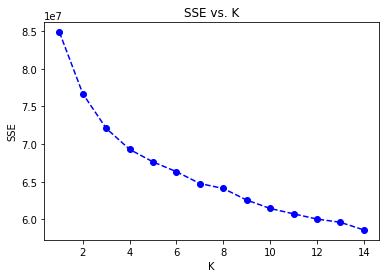

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(list(range(1,15,1)), [i[1] for i in scores], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Picking KMeans with 8 clusters to predict
azdias_dense_rows_pred = pd.DataFrame(scores[7][0].predict(azdias_dense_rows_pca_55), 
                                      columns=['Predictions for AZDIAZ dataset'])

### Discussion 3.1: Apply Clustering to General Population

The error curve seems to decrease quickly from 1 cluster to 4 clusters. The decrease in error when moving from 4 clusters to 8 clusters is slower, but also constant. However, there is a significant slow-down in error decrease for every cluster after that. Hence, I'm picking

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [61]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Clean customer demographics data
print('Cleaning data...')
customers = clean_data(customers, feat_info=feat_info, outlier_columns=outlier_columns, onehotenc=onehotenc)
print('Cleaning data done!\n')
print(len(customers.columns))
# Imputer
print('Imputing data...')
customers_imputed = imputer.transform(customers)
print('Imputing data done!\n')
# StandardScaler
print('Scaling data...')
customers_scaled = scaler.transform(customers_imputed)
print('Scaling data done!')
# PCA
customers_pca_55 = pca_55.transform(customers_scaled)

Cleaning data...
Converting missing value codes into NaNs, ...
### Number of features now: 79
### Number of features now: 79
Encoding category features...
18
### Number of features now: 229
Encoding mixed features...
### Number of features now: 233
Returning the cleaned dataframe...
### Number of features now: 209
Cleaning data done!

209
Imputing data...
Imputing data done!

Scaling data...
Scaling data done!


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_pred = pd.DataFrame(scores[7][0].predict(customers_pca_55), columns=['Predictions for Customers dataset'])

In [63]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
azdias_pred_desc = azdias_dense_rows_pred.groupby('Predictions for AZDIAZ dataset').size()
customers_pred_desc = customers_pred.groupby('Predictions for Customers dataset').size()
pred_desc_comparison = pd.concat([customers_pred_desc, azdias_pred_desc], axis=1)
pred_desc_comparison.columns = ['Predictions for AZDIAZ dataset', 'Predictions for Customers dataset']
pred_desc_comparison['Predictions composition for AZDIAZ dataset'] = pred_desc_comparison['Predictions for AZDIAZ dataset'] / sum(pred_desc_comparison['Predictions for AZDIAZ dataset'])
pred_desc_comparison['Predictions composition for Customers dataset'] = pred_desc_comparison['Predictions for Customers dataset'] / sum(pred_desc_comparison['Predictions for Customers dataset'])
pred_desc_comparison

,Predictions for AZDIAZ dataset,Predictions for Customers dataset,Predictions composition for AZDIAZ dataset,Predictions composition for Customers dataset
0,1449,81594,0.010284,0.102985
1,30852,111734,0.218967,0.141027
2,54430,95912,0.386308,0.121057
3,10932,72871,0.077588,0.091976
4,18479,152623,0.131152,0.192636
5,6411,74312,0.045501,0.093794
6,16969,95133,0.120435,0.120074
7,1376,108108,0.009766,0.136451


In [71]:
[i[0:3] for i in scores[7][0].cluster_centers_]

[array([ 4.35929484, -1.90038678,  2.7846298 ]),
 array([-4.19569834,  0.26896467, -0.08814602]),
 array([-4.162804  ,  0.46116423,  0.55826074]),
 array([-0.13492806, -4.3165182 , -1.25139654]),
 array([ 1.93524287,  3.98745123,  0.36481798]),
 array([-2.24438996, -4.01977502,  0.66591184]),
 array([-1.27586632,  2.46447933, -0.43086786]),
 array([ 4.76286167, -1.37795754, -2.25606866])]

### Discussion 3.3: Compare Customer Data to Demographics Data

According to the table above, we can see that:
    1. Group #0, #1, #4, #6 are overrepresented in the Customers dataset
    2. Group #2, #3, #5, #7 are underrepresented in the Customers dataset

From the first three dimensions that we looked at above, we can rough ly interpret the cluster groups as follow:
    * Group #0: Upper class, young to middle-age, quite financially-minded, also liberal, dreamful, and ambitious
    * Group #1: Lower class, middle-age, financially-minded, and slightly conservative
    * Group #2: Lower class, middle-age, financially-minded, and slightly liberal
    * Group #3: High-middle class, young age, spends inconspicuously, but conservative in political stance
    * Group #4: High-middle class, middle-age to senior, financially savvy, and slightly liberal
    * Group #5: Low-middle class, not financially savvy, liberal
    * Group #6: Low-middle class, financially savvy, slightly conservative
    * Group #7: Upper-class, not financially minded, conservative
    
In that sense, it seems like the customer base is more centric in their political stance, and more financially savvy than the general population. Regardless of the slight differences between the two groups, mostly, they remain quite similar. This means the company can still attract more customers from the population. However, do note that this analysis omits a) sparse rows b) sparse columns.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.